In [65]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import StandardScaler 
import numpy as np
from scipy import stats
import tensorflow as tf



In [66]:
train = pd.read_csv("C:/Users/STRUSI Cosimo/Documents/Uni/Consegna Ramat/projectApprendimento/TrainData1.csv")
test = pd.read_csv("C:/Users/STRUSI Cosimo/Documents/Uni/Consegna Ramat/projectApprendimento/TestData1.csv")
val = pd.read_csv("C:/Users/STRUSI Cosimo/Documents/Uni/Consegna Ramat/projectApprendimento/ValData1.csv")




Preprocessing : scalatura dati di training e test

In [67]:
scale_columns = ['accel_x','accel_y','accel_z','accel_norm',
'gyro_x','gyro_y','gyro_z']

scaler = StandardScaler() 

train_sc = train[scale_columns]
test_sc = test[scale_columns]
val_sc = val[scale_columns]

scaler = scaler.fit(train_sc[scale_columns]) # calcola il massimo e il minimo
scaler.fit(train_sc) 
train_sc = scaler.transform(train_sc) 
test_sc = scaler.transform(test_sc)
val_sc = scaler.transform(val_sc)

train_sc =pd.DataFrame(train_sc,columns = scale_columns)
test_sc =pd.DataFrame(test_sc,columns = scale_columns)
val_sc =pd.DataFrame(val_sc,columns = scale_columns)

train_sc['subject'] = train['subject']
test_sc['subject'] = test['subject']
val_sc['subject'] = val['subject']

train_sc['activity'] = train['activity']
test_sc['activity'] = test['activity']
val_sc['activity'] = val['activity']





trainNew = np.vstack([train[['accel_x','accel_y','accel_z','accel_norm',
'gyro_x','gyro_y','gyro_z','activity','subject']], val[['accel_x','accel_y','accel_z','accel_norm',
'gyro_x','gyro_y','gyro_z','activity','subject']]]) # generate an error
trainNew.shape
trainNew = pd.DataFrame(trainNew,columns=['accel_x','accel_y','accel_z','accel_norm',
'gyro_x','gyro_y','gyro_z','activity','subject'])

train_scNew = trainNew[scale_columns]
test_scNew = test[scale_columns]

scaler = scaler.fit(train_scNew) # calcola il massimo e il minimo
trainNew_sc = scaler.transform(train_scNew) 
testNew_sc = scaler.transform(test_scNew)

trainNew_sc =pd.DataFrame(trainNew_sc,columns = scale_columns)
testNew_sc =pd.DataFrame(test_sc,columns = scale_columns)

trainNew_sc['subject'] = trainNew['subject']
testNew_sc['subject'] = test['subject']

trainNew_sc['activity'] = trainNew['activity']
testNew_sc['activity'] = test['activity']

Preprocessing - create timeseries

In [68]:
# funzione per organizzare il dataset
def create_dataset(X, y, time_steps, step):
    Xs, ys = [], [] # inizializzo due liste vuote
    if step !=0:
      for i in range(0, len(X) - time_steps, step): # ciclo for che parte da zero alla lughezza di (X-time_steps), con passo di step
          v = X.iloc[i:(i + time_steps)].values # del DataFrame prendo i valori che vanno da i fino ad i+time_steps
          labels = y.iloc[i: i + time_steps] # stessa cosa con le labels
          Xs.append(v) # aggiunge un item in coda alla lista
          ys.append(stats.mode(labels)[0][0]) # ad ogni finestra corrisponderà un valore di una classe
    else:
      for i in range(0, len(X) - time_steps, time_steps): # ciclo for che parte da zero alla lughezza di (X-time_steps), con passo di  time_steps
          v = X.iloc[i:(i + time_steps)].values # del DataFrame prendo i valori che vanno da i fino ad i+time_steps
          labels = y.iloc[i: i + time_steps] # stessa cosa con le labels
          Xs.append(v) # aggiunge un item in coda alla lista
          ys.append(stats.mode(labels)[0][0]) # ad ogni finestra corrisponderà un valore di una classe
    return np.array(Xs), np.array(ys).reshape(-1, 1) # output della funzione resistuisce Xs come un array e Ys come un vettore

train = train_sc
test = test_sc
val = val_sc

trainNew = trainNew_sc
testNew = testNew_sc



TIME_STEPS = 200
STEP = 40
# richiamo la funzione per creare X_train e Y_train
X_train, Y_train = create_dataset(
    train[ ['accel_x','accel_y','accel_z','accel_norm',
'gyro_x','gyro_y','gyro_z']],
    train.activity,
    TIME_STEPS,
    STEP
)

TIME_STEPS = 200
STEP = 0
# richiamo la funzione per creare X_val e Y_val

X_val, Y_val = create_dataset(
    val[ ['accel_x','accel_y','accel_z','accel_norm',
'gyro_x','gyro_y','gyro_z']],
    val.activity,
    TIME_STEPS,
    STEP
)

TIME_STEPS = 200
STEP = 0
# richiamo la funzione per creare X_test e Y_test

X_test, Y_test = create_dataset(
    test[ ['accel_x','accel_y','accel_z','accel_norm',
'gyro_x','gyro_y','gyro_z']],
    test.activity,
    TIME_STEPS,
    STEP
)


TIME_STEPS = 200
STEP = 40
# richiamo la funzione per creare X_train e Y_train
X_trainNew, Y_trainNew = create_dataset(
    trainNew[ ['accel_x','accel_y','accel_z','accel_norm',
'gyro_x','gyro_y','gyro_z']],
    trainNew.activity,
    TIME_STEPS,
    STEP
)

TIME_STEPS = 200
STEP = 0
# richiamo la funzione per creare X_test e Y_test

X_testNew, Y_testNew = create_dataset(
    testNew[ ['accel_x','accel_y','accel_z','accel_norm',
'gyro_x','gyro_y','gyro_z']],
    testNew.activity,
    TIME_STEPS,
    STEP
)


Preprocessing - one hot encoding

In [69]:
y_train = Y_train.reshape((-1))
y_test = Y_test.reshape((-1))
y_val = Y_val.reshape((-1))
y_trainNew = Y_trainNew.reshape((-1))
y_testNew = Y_testNew.reshape((-1))
# One Hot encoding 
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_val)
y_trainNew = pd.get_dummies(y_trainNew)
y_testNew = pd.get_dummies(y_testNew)

First model

In [70]:
# Modello
model = keras.Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(100,activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compilazione del modello
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate= 1e-4), metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  batch_size=64, epochs=15)

Epoch 1/15
329/329 [==============================] - 98s 290ms/step - loss: 1.2499 - accuracy: 0.5753 - val_loss: 0.7941 - val_accuracy: 0.7137
Epoch 2/15
329/329 [==============================] - 75s 228ms/step - loss: 0.6845 - accuracy: 0.7359 - val_loss: 0.5904 - val_accuracy: 0.7680
Epoch 3/15
329/329 [==============================] - 76s 232ms/step - loss: 0.4744 - accuracy: 0.8284 - val_loss: 0.3696 - val_accuracy: 0.8799
Epoch 4/15
329/329 [==============================] - 76s 231ms/step - loss: 0.3835 - accuracy: 0.8557 - val_loss: 0.3778 - val_accuracy: 0.8799
Epoch 5/15
329/329 [==============================] - 77s 234ms/step - loss: 0.3405 - accuracy: 0.8801 - val_loss: 0.2910 - val_accuracy: 0.9274
Epoch 6/15
329/329 [==============================] - 74s 224ms/step - loss: 0.2736 - accuracy: 0.9189 - val_loss: 0.2588 - val_accuracy: 0.9369
Epoch 7/15
329/329 [==============================] - 73s 221ms/step - loss: 0.2580 - accuracy: 0.9283 - val_loss: 0.2650 - val_ac

In [71]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 100)               43200     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dense_11 (Dense)            (None, 6)                 606       
                                                                 
Total params: 53,906
Trainable params: 53,906
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 0, 'epoca')

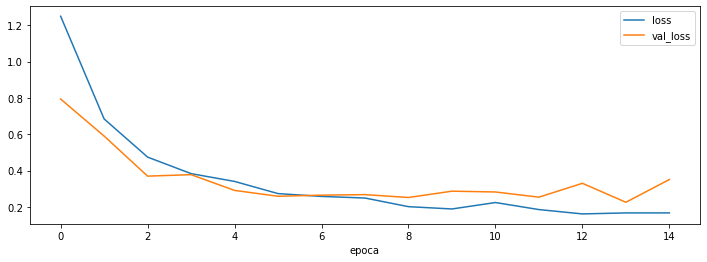

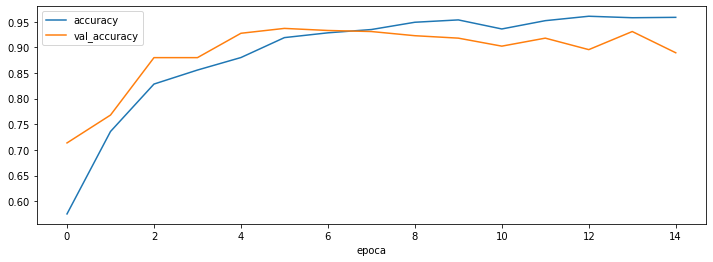

In [72]:
fig, axs = plt.subplots(figsize=(12, 4))
history_df1 = pd.DataFrame(history.history)
history_df1.loc[:, ['loss', 'val_loss']].plot(ax=axs)
axs.set_xlabel("epoca")

fig, axs = plt.subplots(figsize=(12, 4))
history_df1.loc[:, ['accuracy', 'val_accuracy']].plot(ax=axs)
axs.set_xlabel("epoca")

In [73]:
# Modello allenato su tutti i dati di training e validation
model = keras.Sequential()
model.add(LSTM(100, input_shape=(X_trainNew.shape[1],X_trainNew.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(100,activation='relu'))
model.add(Dense(y_trainNew.shape[1], activation='softmax'))

# Compilazione del modello
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate= 1e-4), metrics=['accuracy'])

history = model.fit(X_trainNew, y_trainNew,  batch_size=64, epochs=15)

Epoch 1/15
444/444 [==============================] - 113s 247ms/step - loss: 1.1066 - accuracy: 0.6096
Epoch 2/15
444/444 [==============================] - 109s 245ms/step - loss: 0.6703 - accuracy: 0.7451
Epoch 3/15
444/444 [==============================] - 108s 242ms/step - loss: 0.4300 - accuracy: 0.8556
Epoch 4/15
444/444 [==============================] - 108s 243ms/step - loss: 0.2929 - accuracy: 0.9202
Epoch 5/15
444/444 [==============================] - 111s 250ms/step - loss: 0.2838 - accuracy: 0.9245
Epoch 6/15
444/444 [==============================] - 109s 245ms/step - loss: 0.2094 - accuracy: 0.9448
Epoch 7/15
444/444 [==============================] - 108s 243ms/step - loss: 0.1747 - accuracy: 0.9547
Epoch 8/15
444/444 [==============================] - 115s 259ms/step - loss: 0.1581 - accuracy: 0.9591
Epoch 9/15
444/444 [==============================] - 106s 239ms/step - loss: 0.1503 - accuracy: 0.9615
Epoch 10/15
444/444 [==============================] - 104s 234m

First model - Evaluate first model

44/44 [==============================] - 2s 54ms/step


INFO:tensorflow:Assets written to: modelloLSTM1\assets


INFO:tensorflow:Assets written to: modelloLSTM1\assets


0.935832732516222 [0.95241528 0.99495314 0.99783706 0.98485941 0.96971882 0.97188176] [0.73758865 0.96969697 0.99082569 1.         0.85185185 0.94101124] [0.78195489 0.97709924 1.         0.92758621 0.88461538 0.9490085 ]


Text(0.5, 87.0, 'Output')

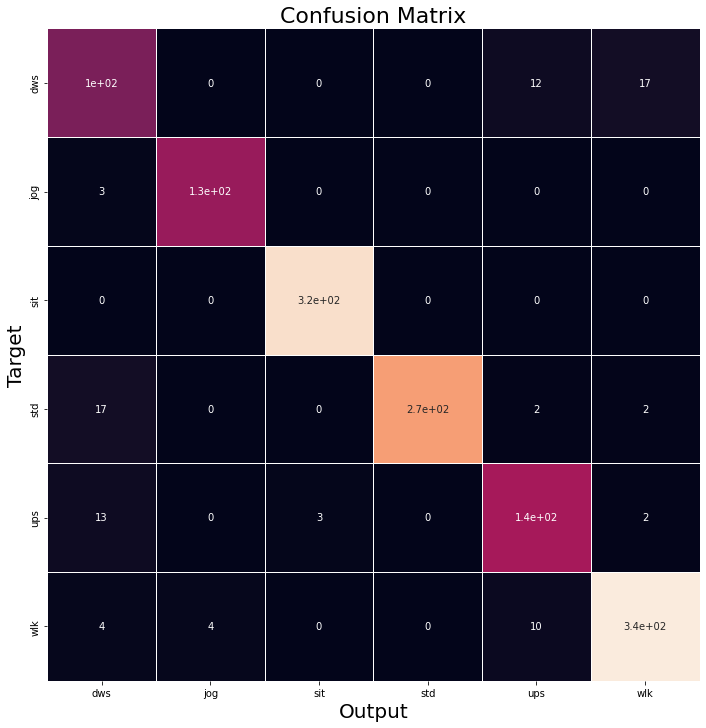

In [77]:
model.evaluate(X_testNew,y_testNew)

# Test del modello allenato
y_hat = model.predict(X_testNew) # output dell'ultimo strato del modello
predict = np.argmax(y_hat, axis=1) # ricodifico i valori predetti
label = np.argmax(y_testNew.values, axis=1) # ricodifico i valori veri


model.save("modelloLSTM1")



def statistical_measures(predict, label):  
  cnf_matrix = confusion_matrix(label, predict)
  # falsi positivi
  FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
  # falsi negativi
  FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
  # veri positivi
  TP = np.diag(cnf_matrix)
  # veri negativi
  TN = cnf_matrix.sum() - (FP + FN + TP)
  # assegno il tipo di variabile
  FP = FP.astype(float)
  FN = FN.astype(float)
  TP = TP.astype(float)
  TN = TN.astype(float)
  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP / (TP + FN)
  # Specificity or true negative rate
  TNR = TN / (TN + FP)
  # Precision or positive predictive value
  PPV = TP / (TP + FP)
  # Negative predictive value
  NPV = TN / (TN + FN)
  # Fall out or false positive rate
  FPR = FP / (FP + TN)
  # False negative rate
  FNR = FN / (TP + FN)
  # False discovery rate
  FDR = FP / (TP + FP)
  # Overall accuracy for each class
  ACC = (TP + TN) / (TP + FP + FN + TN)
  ACC_TOT = (cnf_matrix.diagonal()).sum() / len(label)
  return ACC_TOT, ACC, PPV, TPR # output

acc_tot, acc_classes, precision_classes, recall_classes = statistical_measures(predict, label) # richiamo la funzione
print(acc_tot, acc_classes, precision_classes, recall_classes)

cm = (confusion_matrix(label, predict))
true_labels = np.unique(Y_test) # creo il vettore delle classi possibili




df_cm = pd.DataFrame(cm, index = [i for i in true_labels], columns = [i for i in true_labels]) # percetuali di quanti esempi per classe sono stati classificati correttamente
df_cm.head()

plt.figure(figsize = (12,12)) # size della figura
sn.heatmap(df_cm, annot=True,cbar=False, linewidths=.8, square=True, xticklabels=true_labels,
            yticklabels=true_labels ) # confusion matrix
plt.title('Confusion Matrix', fontsize=22)
plt.ylabel('Target', fontsize=20)
plt.xlabel('Output', fontsize=20)

Second model

In [78]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
model = keras.Sequential()
model.add(LSTM(units=100, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(50))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate= 1e-4), metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  batch_size=64, epochs=15)

Epoch 1/15
329/329 [==============================] - 441s 1s/step - loss: 1.0022 - accuracy: 0.6270 - val_loss: 0.5251 - val_accuracy: 0.8412
Epoch 2/15
329/329 [==============================] - 483s 1s/step - loss: 0.3338 - accuracy: 0.9083 - val_loss: 0.2904 - val_accuracy: 0.9261
Epoch 3/15
329/329 [==============================] - 484s 1s/step - loss: 0.2397 - accuracy: 0.9421 - val_loss: 0.2793 - val_accuracy: 0.9267
Epoch 4/15
329/329 [==============================] - 472s 1s/step - loss: 0.1910 - accuracy: 0.9545 - val_loss: 0.2112 - val_accuracy: 0.9471
Epoch 5/15
329/329 [==============================] - 441s 1s/step - loss: 0.1700 - accuracy: 0.9573 - val_loss: 0.2427 - val_accuracy: 0.9342
Epoch 6/15
329/329 [==============================] - 432s 1s/step - loss: 0.1559 - accuracy: 0.9611 - val_loss: 0.1893 - val_accuracy: 0.9498
Epoch 7/15
329/329 [==============================] - 483s 1s/step - loss: 0.1321 - accuracy: 0.9665 - val_loss: 0.1814 - val_accuracy: 0.9532

Text(0.5, 0, 'epoca')

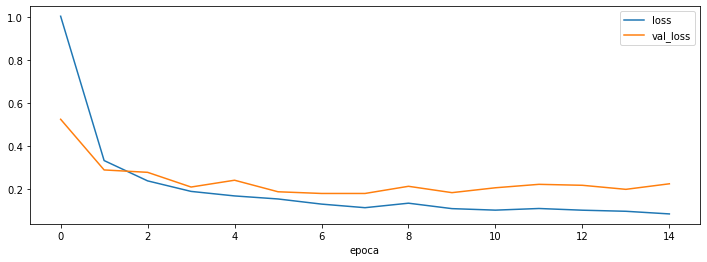

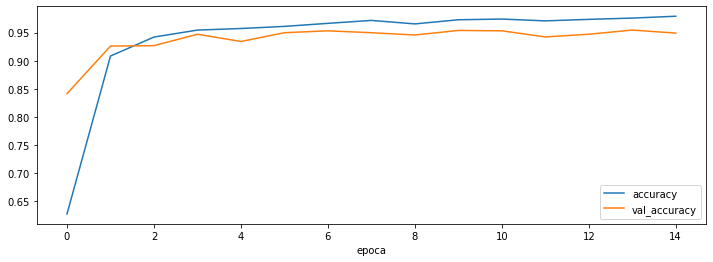

In [81]:
fig, axs = plt.subplots(figsize=(12, 4))
history_df1 = pd.DataFrame(history.history)
history_df1.loc[:, ['loss', 'val_loss']].plot(ax=axs)
axs.set_xlabel("epoca")

fig, axs = plt.subplots(figsize=(12, 4))
history_df1.loc[:, ['accuracy', 'val_accuracy']].plot(ax=axs)
axs.set_xlabel("epoca")

In [84]:
# Modello allenato su tutti i dati 
model = keras.Sequential()
model.add(LSTM(units=100, input_shape=(X_trainNew.shape[1],X_trainNew.shape[2]), return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(50))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dropout(0.2))
model.add(Dense(y_trainNew.shape[1], activation='softmax'))

# Compilazione del modello
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate= 1e-4), metrics=['accuracy'])

history = model.fit(X_trainNew, y_trainNew,  batch_size=64, epochs=15)

Epoch 1/15
444/444 [==============================] - 403s 894ms/step - loss: 0.8645 - accuracy: 0.6977
Epoch 2/15
444/444 [==============================] - 395s 889ms/step - loss: 0.2610 - accuracy: 0.9346
Epoch 3/15
444/444 [==============================] - 394s 887ms/step - loss: 0.1848 - accuracy: 0.9556
Epoch 4/15
444/444 [==============================] - 393s 886ms/step - loss: 0.2206 - accuracy: 0.9457
Epoch 5/15
444/444 [==============================] - 394s 887ms/step - loss: 0.1655 - accuracy: 0.9594
Epoch 6/15
444/444 [==============================] - 394s 887ms/step - loss: 0.1432 - accuracy: 0.9652
Epoch 7/15
444/444 [==============================] - 440s 991ms/step - loss: 0.1155 - accuracy: 0.9720
Epoch 8/15
444/444 [==============================] - 528s 1s/step - loss: 0.1066 - accuracy: 0.9728
Epoch 9/15
444/444 [==============================] - 515s 1s/step - loss: 0.1011 - accuracy: 0.9740
Epoch 10/15
444/444 [==============================] - 560s 1s/step - 

Second modelEvaluate second model

44/44 [==============================] - 5s 109ms/step


INFO:tensorflow:Assets written to: modelloLSTM2\assets


INFO:tensorflow:Assets written to: modelloLSTM2\assets


0.9343907714491708 [0.95674117 0.99134823 0.99927902 0.98269647 0.95962509 0.97909156] [0.77037037 0.94074074 0.99692308 0.98540146 0.78089888 0.97647059] [0.78195489 0.96946565 1.         0.93103448 0.89102564 0.94050992]


Text(0.5, 87.0, 'Output')

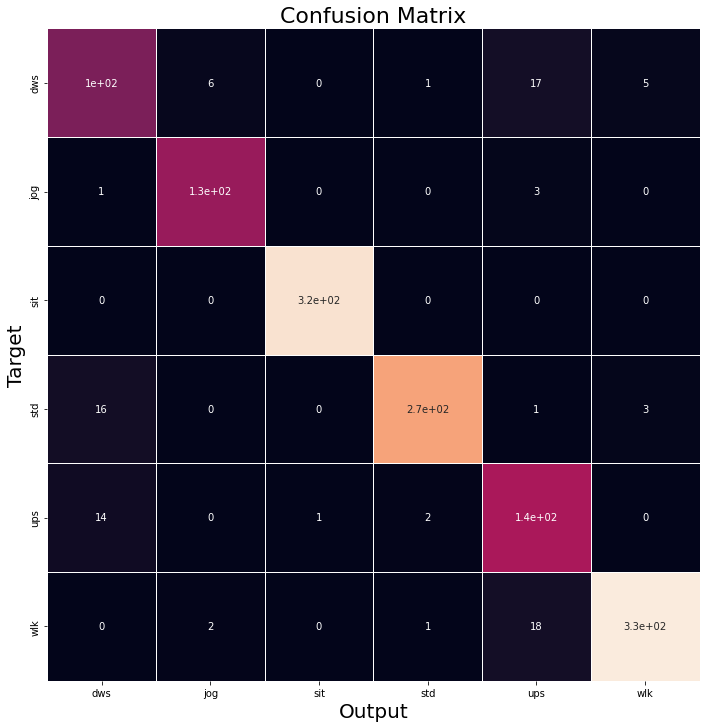

In [86]:
model.evaluate(X_testNew,y_testNew)
# Test del modello allenato
y_hat = model.predict(X_testNew) # output dell'ultimo strato del modello
predict = np.argmax(y_hat, axis=1) # ricodifico i valori predetti
label = np.argmax(y_testNew.values, axis=1) # ricodifico i valori veri


model.save("modelloLSTM2")


acc_tot, acc_classes, precision_classes, recall_classes = statistical_measures(predict, label) # richiamo la funzione
print(acc_tot, acc_classes, precision_classes, recall_classes)

cm = (confusion_matrix(label, predict))
true_labels = np.unique(Y_testNew) # creo il vettore delle classi possibili


df_cm = pd.DataFrame(cm, index = [i for i in true_labels], columns = [i for i in true_labels]) # percetuali di quanti esempi per classe sono stati classificati correttamente
df_cm.head()

plt.figure(figsize = (12,12)) # size della figura
sn.heatmap(df_cm, annot=True,cbar=False, linewidths=.8, square=True, xticklabels=true_labels,
            yticklabels=true_labels ) # confusion matrix
plt.title('Confusion Matrix', fontsize=22)
plt.ylabel('Target', fontsize=20)
plt.xlabel('Output', fontsize=20)

In [83]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 200, 100)          43200     
                                                                 
 lstm_8 (LSTM)               (None, 200, 50)           30200     
                                                                 
 dropout_7 (Dropout)         (None, 200, 50)           0         
                                                                 
 lstm_9 (LSTM)               (None, 50)                20200     
                                                                 
 dense_14 (Dense)            (None, 50)                2550      
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_15 (Dense)            (None, 25)               

In [80]:
a=5